In [61]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import random
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [44]:

# Initialize an empty list to store the images
face_points = []

# Use glob to find all .png files in the '01_Indoor' and '01_Outdoor' folders
image_folder = r'.\300W\*\*.png'

# Get all image paths from both folders
face_images = glob(pathname=image_folder)

for i in face_images:
    face_points.append(i.replace(".png", ".pts"))


# Now face_images contains all the images loaded from both folders
print(face_images[:10])
print(face_points[:10])


['.\\300W\\01_Indoor\\indoor_001.png', '.\\300W\\01_Indoor\\indoor_002.png', '.\\300W\\01_Indoor\\indoor_003.png', '.\\300W\\01_Indoor\\indoor_004.png', '.\\300W\\01_Indoor\\indoor_005.png', '.\\300W\\01_Indoor\\indoor_006.png', '.\\300W\\01_Indoor\\indoor_007.png', '.\\300W\\01_Indoor\\indoor_008.png', '.\\300W\\01_Indoor\\indoor_009.png', '.\\300W\\01_Indoor\\indoor_010.png']
['.\\300W\\01_Indoor\\indoor_001.pts', '.\\300W\\01_Indoor\\indoor_002.pts', '.\\300W\\01_Indoor\\indoor_003.pts', '.\\300W\\01_Indoor\\indoor_004.pts', '.\\300W\\01_Indoor\\indoor_005.pts', '.\\300W\\01_Indoor\\indoor_006.pts', '.\\300W\\01_Indoor\\indoor_007.pts', '.\\300W\\01_Indoor\\indoor_008.pts', '.\\300W\\01_Indoor\\indoor_009.pts', '.\\300W\\01_Indoor\\indoor_010.pts']


In [45]:
# Function to read points from a .pts file
def read_pts_file(pts_file):
    points = []
    with open(pts_file, 'r') as file:
        lines = file.readlines()[3:-1]  # Skip the first 3 lines and the last curly brace
        for line in lines:
            x, y = line.strip().split()
            points.append((float(x), float(y)))
    return points

In [53]:
# Function to resize points based on new image size
def resize_points(points, old_size, new_size):
    old_width, old_height = old_size
    new_width, new_height = new_size
    scale_x = new_width / old_width
    scale_y = new_height / old_height
    resized_points = [(x * scale_x, y * scale_y) for (x, y) in points]
    return resized_points

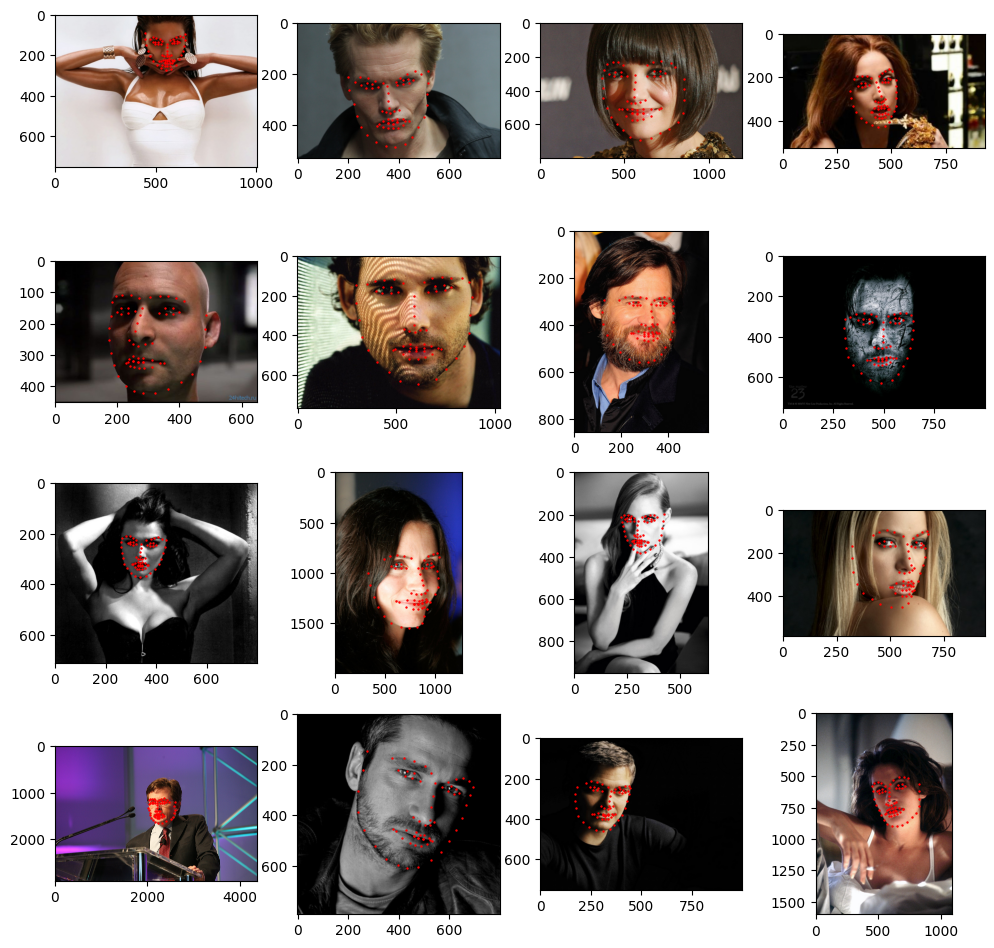

In [55]:
def plot_from_image_path(rows, columns, image_list):
    fig = plt.figure(figsize=(12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        image_file = image_list[i-1]
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Construct the corresponding .pts file path (assuming it's in the same folder with .pts extension)
        pts_file = os.path.splitext(image_file)[0] + '.pts'
        
        # Read the points from the .pts file
        if os.path.exists(pts_file):
            points = read_pts_file(pts_file)
        else:
            points = []
            
        
        
        plt.imshow(image)
        
        # Plot the points if available
        if points:
            xs, ys = zip(*points)  # Separate the x and y coordinates
            plt.scatter(xs, ys, c='red', s=0.5)  # Plot points in red
        
    plt.imshow
    
plot_from_image_path(4, 4, face_images)

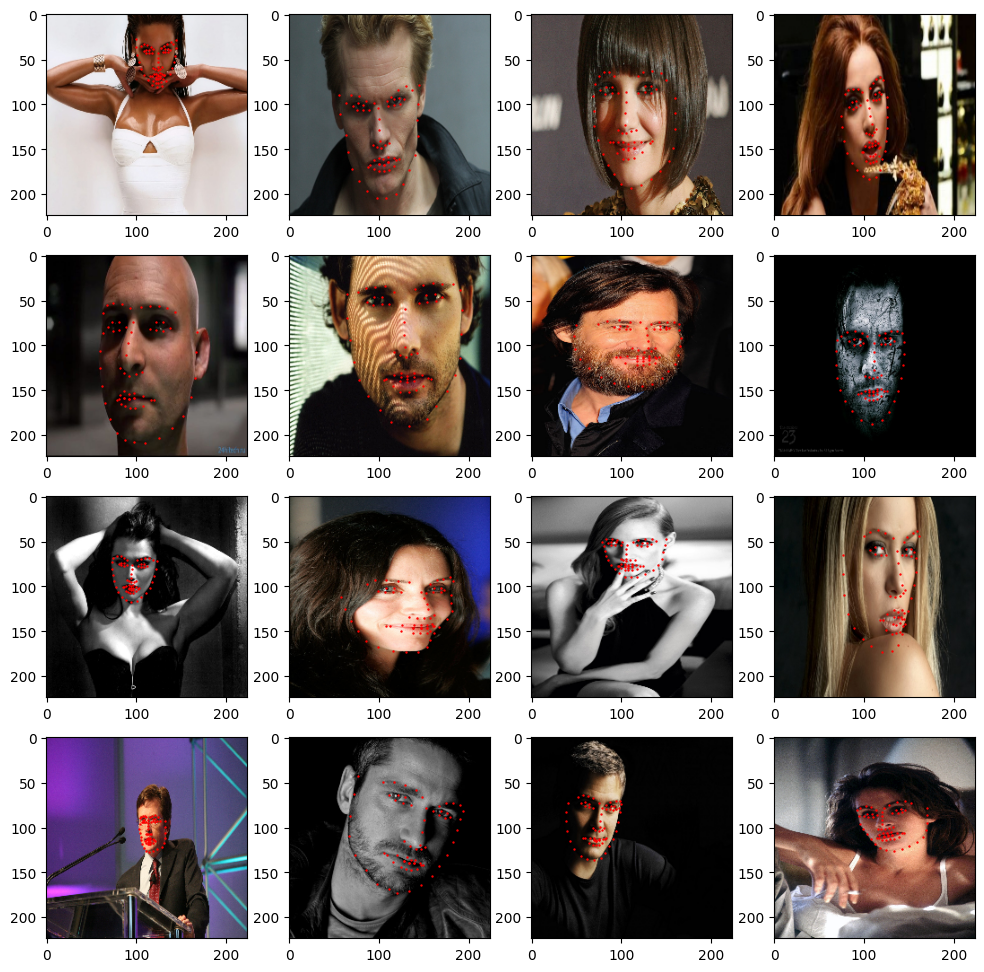

In [54]:
def plot_from_image_path(rows, columns, image_list):
    fig = plt.figure(figsize=(12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        image_file = image_list[i-1]
        image = cv2.imread(image_file)
        
        
        # Get the original image size
        old_size = image.shape[1], image.shape[0]  # (width, height)
        
        # Resize the image to 224x224
        new_size = (224, 224)
        image_resized = cv2.resize(image, new_size)
        
        # Convert from BGR to RGB for displaying
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        
        
        # Construct the corresponding .pts file path (assuming it's in the same folder with .pts extension)
        pts_file = os.path.splitext(image_file)[0] + '.pts'
        
        # Read the points from the .pts file
        if os.path.exists(pts_file):
            points = read_pts_file(pts_file)
            # Resize the points to match the resized image
            points_resized = resize_points(points, old_size, new_size)
        else:
            points_resized = []
            
        
        
        plt.imshow(image_resized)
        
        # Plot the points if available
        if points:
            xs, ys = zip(*points_resized)  # Separate the x and y coordinates
            plt.scatter(xs, ys, c='red', s=0.5)  # Plot points in red
        
    plt.imshow
    
plot_from_image_path(4, 4, face_images)

In [58]:
df = pd.DataFrame(data = {'face_images' : face_images, 'face_points' : face_points})
df_train, df_test = train_test_split(df, test_size = 0.15, random_state=42)
df_train, df_val = train_test_split(df_train, test_size = 0.1765, random_state=42)

# Print the shapes of the resulting splits
print("Training set size:", df_train.shape)
print("Validation set size:", df_val.shape)
print("Test set size:", df_test.shape)

Training set size: (419, 2)
Validation set size: (91, 2)
Test set size: (90, 2)


In [69]:
# Custom Dataset Class
class FacePointsDataset(Dataset):
    def __init__(self, image_paths, points_paths, transform=None):
        self.image_paths = image_paths
        self.points_paths = points_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load points using the provided read_pts_file function
        points = read_pts_file(self.points_paths[idx])
        
        # Apply transformations (resizing, normalization, augmentation)
        if self.transform:
            image, points = self.transform(image, points)
        
        # Convert image and points to tensors
        image = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32)  # (C, H, W)
        points = torch.tensor(points, dtype=torch.float32)
        
        return image, points

# Custom Transformations for Augmentation
class CustomTransforms:
    def __init__(self, resize=(224, 224), rotation_range=30, crop_size=(200, 200)):
        self.resize = resize
        self.rotation_range = rotation_range
        self.crop_size = crop_size
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization to [0, 1]
        ])
    
    def __call__(self, image, points):
        old_size = (image.shape[1], image.shape[0])  # (width, height)
        
        # Resize image and points
        image, points = self.resize_image_and_points(image, points, old_size)
        
        # Data augmentation
        if random.random() > 0.5:
            image, points = self.random_rotation(image, points)
        if random.random() > 0.5:
            image, points = self.horizontal_flip(image, points)
        if random.random() > 0.5:
            image, points = self.random_crop(image, points)
        
        # Normalize the image to [0, 1]
        image = self.normalize(image)
        
        return image, points
    
    def resize_image_and_points(self, image, points, old_size):
        # Resize image to target size
        new_size = self.resize
        image_resized = cv2.resize(image, new_size)
        
        # Resize points using the existing resize_points function
        points_resized = resize_points(points, old_size, new_size)
        
        return image_resized, points_resized
    
    def random_rotation(self, image, points):
        angle = random.uniform(-self.rotation_range, self.rotation_range)
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        
        # Rotate the image
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        image_rotated = cv2.warpAffine(image, M, (w, h))
        
        # Rotate the points
        ones = np.ones((points.shape[0], 1))
        points_homogeneous = np.hstack([points, ones])
        points_rotated = M.dot(points_homogeneous.T).T
        
        return image_rotated, points_rotated
    
    def horizontal_flip(self, image, points):
        image_flipped = cv2.flip(image, 1)
        
        # Convert points to a NumPy array for easier manipulation
        points_flipped = np.array(points).copy()
    
        # Flip the points horizontally
        points_flipped[:, 0] = image.shape[1] - points_flipped[:, 0]
        
        return image_flipped, points_flipped
    
    def random_crop(self, image, points):
        h, w, _ = image.shape
        crop_h, crop_w = self.crop_size
        
        # Ensure the crop size doesn't exceed the image size
        if crop_h > h or crop_w > w:
            crop_h, crop_w = h, w
        
        top = random.randint(0, h - crop_h)
        left = random.randint(0, w - crop_w)
        
        # Crop the image
        image_cropped = image[top:top+crop_h, left:left+crop_w]
        
        # Adjust the points
        points_cropped = points.copy()
        points_cropped[:, 0] -= left
        points_cropped[:, 1] -= top
        
        # Resize the cropped image back to the original size (224x224)
        image_resized = cv2.resize(image_cropped, self.resize)
        
        # Scale the points back to the resized image
        points_resized = resize_points(points_cropped, (crop_w, crop_h), self.resize)
        
        return image_resized, points_resized

TypeError: list indices must be integers or slices, not tuple

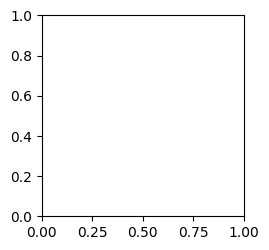

In [70]:
# New function to plot augmented images and points
def plot_augmented_data(dataset, rows, columns):
    fig = plt.figure(figsize=(12, 12))
    
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        
        # Get a random sample from the dataset (augmented image and points)
        idx = random.randint(0, len(dataset) - 1)
        image, points = dataset[idx]
        
        # Convert the image tensor to numpy array and transpose to (H, W, C)
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * 255).astype(np.uint8)  # Undo normalization to [0, 255] for visualization
        
        # Plot the augmented image
        plt.imshow(image_np)
        
        # Plot the points if available
        if points is not None:
            xs, ys = zip(*points.numpy())  # Convert points tensor to numpy and separate x, y coordinates
            plt.scatter(xs, ys, c='red', s=10)  # Plot points in red

    plt.show()


transform = CustomTransforms()

dataset = FacePointsDataset(face_images, face_points, transform=transform)


# Example usage to plot augmented dataset
plot_augmented_data(dataset, rows=4, columns=4)